# Echo top height calculation from NEXRAD PPI volume data: 

An echo top is the radar indicated top of an area of precipitation. This notebook demonstrates how to calculate the echo top height (ETH) in a NEXRAD PPI volume scan to determine the maximum elevation angle at which a certain reflectivity threshold is exceeded.

This example uses the echo top height (ETH) calculation code written by [Valentin Louf](https://github.com/vlouf), available at this [github repository](https://github.com/vlouf/eth_radar.git).

---

## Overview

The notebook applies the modified ETH algorithm proposed by [Lakshmanan et al. (2013)](https://journals.ametsoc.org/view/journals/wefo/28/2/waf-d-12-00084_1.xml) to a NEXRAD PPI volume scan.

The modified algorithm comprises these steps:

1. Find the maximum elevation angle ($\theta_{b}$) where reflectivity ($Z_{b}$) exceeds the echo-top reflectivity threshold.
If $\theta_{b}$ is not the highest elevation scan in the virtual volume, obtain the reflectivity value ($Z_{a}$) at the next higher elevation angle ($\theta_{a}$). Then, the echo-top height is given by the height of the radar beam at an elevation angle:

$$\theta_T = (Z_T - Z_a) \frac{\theta_b - \theta_a}{Z_b - Z_a} + \theta_b$$

where $Z_T$ is the threshold value (e.g., 0 dBZ, 18 dBZ) used to compute the echo top.

2. If $\theta_{b}$ is the highest elevation scan available, set $\theta_{T} = \theta_{b} + \beta/2$, where $\beta$ is the half-power beamwidth. This condition is met far away from the radar if higher-elevation scans have shorter ranges than a base “surveillance” scan and very close to the radar if the highest-elevation scan does not sample the top of the cloud. Under these circumstances, $\theta_{T}$ is set to be the top of the beam containing dBZ $\geq Z_T$; that is, the traditional echo-top algorithm is followed when there are no data available from a higher-elevation scan.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Required | Geospatial plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |
| [Numba](https://numba.pydata.org/) | Helpful | Familiarity with vectorization/optimization of Python functions|

- **Time to learn**: 25 minutes

## Imports

In [1]:
import pyart
import numpy as np
from echotop import cloud_top_height, grid_cloud_top
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/mgrover/mambaforge/envs/radar-cookbook-dev/lib/python3.9/site-packages/echotop/echotop.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cloud_top_height(
/Users/mgrover/mambaforge/envs/radar-cookbook-dev/lib/python3.9/site-packages/echotop/echotop.py:132: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def column_max_reflectivity(r, azimuth, elevati

## Define our function to compute ETH on a uniform x-y grid

The input file can be a Next Generation Weather Radar (NEXRAD) archive file from Amazon Web Services. We will remotely access  this file and use a reflectivity threshold `eth_thld` to define our echo tops.

In [17]:
def compute_eth(infile, eth_thld=0):
    """
    Compute the Echo Top Height on a grid
    
    Parameters
    ==========
    infile (str): Filename of NEXRAD Level 2 Archive file. The files hosted by
    at the NOAA National Climate Data Center [1]_ as well as on the
    UCAR THREDDS Data Server [2]_ have been tested. Other NEXRAD
    Level 2 Archive files may or may not work. Message type 1 file
    and message type 31 files are supported.
    
    eth_thld (float): Reflectivity threshold for which we want to compute 
    the echo top height.
        
    Returns:
    ========
    cth_grid: ndarray <x, y>
        Echo top height on a grid of dimension (x, y).  
        
    References
    ----------
    .. [1] http://www.ncdc.noaa.gov/
    .. [2] http://thredds.ucar.edu/thredds/catalog.html
    """
    # Reading NEXRAD L2 data stored on AWS cloud
    
    radar = pyart.io.read_nexrad_archive(infile)

    r = radar.range['data']
    azimuth = radar.azimuth['data']
    elevation = radar.elevation['data']
    refl = np.array(radar.fields['reflectivity']['data'])
    st_sweep = radar.sweep_start_ray_index['data']
    ed_sweep = radar.sweep_end_ray_index['data']

    # Compute ETH. The 'echotop' package uses @jit decorator to optimize 
    # the 'cloud_top_height' function
    cth = cloud_top_height(r, azimuth, elevation, st_sweep, ed_sweep, refl, eth_thld=eth_thld)

    # Grid data
    th = 450 - azimuth[slice(st_sweep[0], ed_sweep[0] + 1)]
    th[th < 0] += 360

    R, A = np.meshgrid(r, th)
    x = R * np.cos(np.pi * A / 180)
    y = R * np.sin(np.pi * A / 180)

    xgrid = np.arange(-MAX_RANGE, MAX_RANGE + RANGE_STEP / 2, RANGE_STEP).astype(np.int32)
    [X, Y] = np.meshgrid(xgrid, xgrid)
    cth_grid = grid_cloud_top(
        cth, x, y, X, Y, nnearest=24, maxdist=2500
    )  # nearest=24 should be enough to sample out to 2500m on a 1000m grid
    cth_grid = np.ma.masked_invalid(cth_grid).astype(np.int32).filled(FILLVALUE)

    return cth_grid

## Read and plot reflectivity and velocity fields for a sample file 

/Users/mgrover/mambaforge/envs/radar-cookbook-dev/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


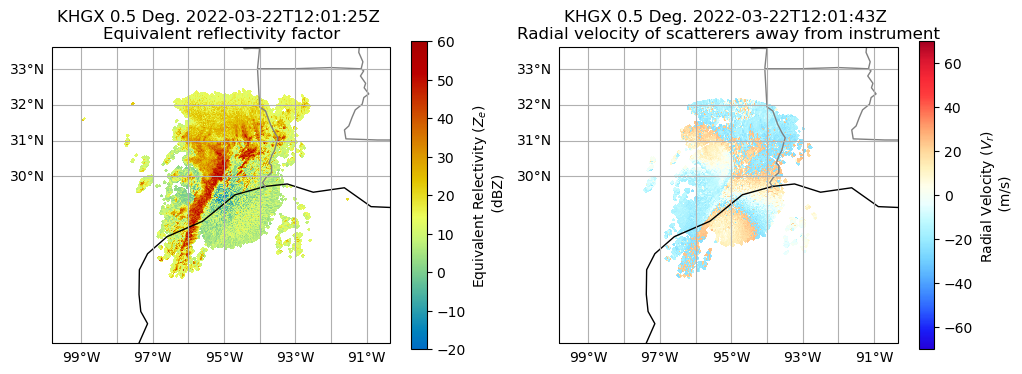

In [10]:
aws_nexrad_level2_file = (
    "s3://noaa-nexrad-level2/2022/03/22/KHGX/KHGX20220322_120125_V06"
)

radar = pyart.io.read_nexrad_archive(aws_nexrad_level2_file)


fig = plt.figure(figsize=(12, 4))
display = pyart.graph.RadarMapDisplay(radar)

ax = plt.subplot(121, projection=ccrs.PlateCarree())

display.plot_ppi_map(
    "reflectivity",
    sweep=0,
    ax=ax,
    colorbar_label="Equivalent Relectivity ($Z_{e}$) \n (dBZ)",
    vmin=-20,
    vmax=60,
)

ax = plt.subplot(122, projection=ccrs.PlateCarree())

display.plot_ppi_map(
    "velocity",
    sweep=1,
    ax=ax,
    colorbar_label="Radial Velocity ($V_{r}$) \n (m/s)",
    vmin=-70,
    vmax=70,
)

## Define some global constants and compute the ETH on a horizontally uniform grid

These constants are required by the `compute_eth` function to grid the data from polar coordinates to a horizontally uniform grid. These three constants are defined as:

`FILLVALUE` (Value to replace missing data)\
`RANGE_STEP` (Uniform horizontal grid spacing in x and y dimensions)\
`MAX_RANGE` (Maximum range up to which ETH to be calculated from gridded data)

In [18]:
FILLVALUE: int = -9999 
RANGE_STEP: int = 1000 
MAX_RANGE: float = 250e3 

cth_grid = compute_eth(aws_nexrad_level2_file, eth_thld=20)

[[-33.   15.5  14.  ... -33.  -33.  -33. ]
 [-33.    7.    9.5 ... -33.  -33.  -33. ]
 [ 10.5  21.  -33.  ... -33.  -33.  -33. ]
 ...
 [-21.  -20.5 -20.5 ... -32.5 -32.5 -32.5]
 [-19.5 -19.5 -20.  ... -32.5 -32.5 -32.5]
 [-20.  -14.5 -12.5 ... -32.5 -32.5 -32.5]]


/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_82517/2242112522.py:55: RuntimeWarning: invalid value encountered in cast
  cth_grid = np.ma.masked_invalid(cth_grid).astype(np.int32).filled(FILLVALUE)


## Plot the gridded echo/cloud top height using matplotlib

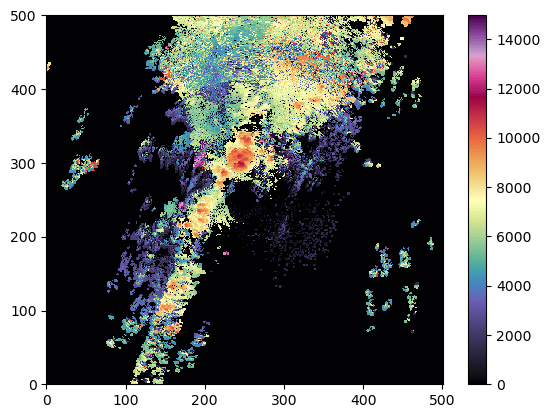

In [19]:
p = plt.pcolormesh(cth_grid,
                   vmin=0,
                   vmax=15000,
                   cmap='pyart_ChaseSpectral')

plt.colorbar(mappable=p)

---

## Summary
Within this example, we walked through how to access ARM data from a field campaign in Texas, plot a quick look of the RHI scan data, and grid our RHI data from native (polar) coordinates to a uniform range-height Caretsian grid.

## Resources and References
* [NOAA NEXRAD on AWS](https://registry.opendata.aws/noaa-nexrad/)
* [Read NEXRAD on AWS](https://arm-doe.github.io/pyart/examples/io/plot_nexrad_data_aws.html#sphx-glr-examples-io-plot-nexrad-data-aws-py)
* Py-ART:
    - Helmus, J.J. & Collis, S.M., (2016). The Python ARM Radar Toolkit (Py-ART), a Library for Working with Weather Radar Data in the Python Programming Language. Journal of Open Research Software. 4(1), p.e25. DOI: http://doi.org/10.5334/jors.119
* Echo-top height algorithm:
    - Lakshmanan, V., Hondl, K., Potvin, C. K., & Preignitz, D. (2013). An improved method for estimating radar echo-top height. Weather and Forecasting, 28(2), 481-488. DOI: https://doi.org/10.1175/WAF-D-12-00084.1